##  基本模块导入与构建

In [1]:
# import modules

import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision

from IPython.display import display
%matplotlib inline

In [2]:
# define some common-used constant variables

use_cuda = torch.cuda.is_available()

In [5]:
# prepare dataset

path = {
    'datasets': os.path.join(os.getcwd(), 'datasets'), 
    'models': os.path.join(os.getcwd(), 'models'),
    'outputs_aux': os.path.join(os.getcwd(), 'outputs_aux')
}

for k,path_val in path.items():
    if not os.path.isdir(path_val):
        os.mkdir(path_val)

transform_sets = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

params = {
    'datasets': {
        'root': path['datasets'], 
        'download': True,
        'transform': transform_sets
    }
}

data = {
    'train': torchvision.datasets.MNIST(train=True, **params['datasets']), 
    'test': torchvision.datasets.MNIST(train=False, **params['datasets']), 
}

Processing...
Done!


In [6]:
# set dataloader

batch_size = 100
n_class = 10
dataloader = {}

## dataloader-train

dataloader['train'] = torch.utils.data.DataLoader(dataset=data['train'], batch_size=batch_size, shuffle=True)

## dataloader-valid & dataloader-test

### auxiliary components

indicies = {
    'valid': range(len(data['test'])//2),
    'test': range(len(data['test'])//2, len(data['test']))
}
sampler = {
    'valid': torch.utils.data.sampler.SubsetRandomSampler(indices=indicies['valid']),
    'test': torch.utils.data.sampler.SubsetRandomSampler(indices=indicies['test'])
}

### dataloder definition

dataloader['valid'] = torch.utils.data.DataLoader(dataset=data['test'], batch_size=batch_size, 
                                                  sampler=sampler['valid'])

dataloader['test'] = torch.utils.data.DataLoader(dataset=data['test'], batch_size=batch_size, 
                                                  sampler=sampler['test'])

## 查看三个迭代器的信息

In [7]:
def vis_dist_dataloader(cls):
    count = {i:0 for i in range(n_class)}
    for i, data in enumerate(dataloader[cls]):
        xs, ys = data
        for y in ys:
            count[y] += 1
            
    count = [count[i] for i in range(n_class)]
    display(pd.DataFrame(data=count))
    plt.bar(left=np.arange(n_class), height=count)
    plt.xlabel('digit_class')
    plt.ylabel('count_total_samples')
    plt.title('simple stat: data[{}]'.format(cls))
    filename_base = 'stat-{}'.format(cls)
    filename_full = os.path.join(path['outputs_aux'], filename_base)
    plt.savefig(filename_full)

,0
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851
9,5949


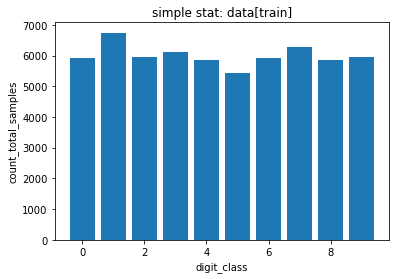

In [8]:
vis_dist_dataloader('train')

,0
0,460
1,571
2,530
3,500
4,500
5,456
6,462
7,512
8,489
9,520


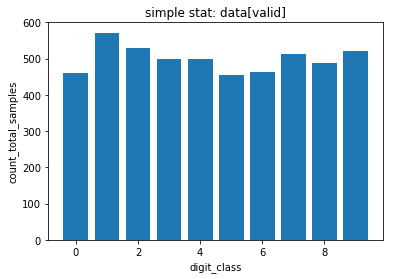

In [9]:
vis_dist_dataloader('valid')

,0
0,520
1,564
2,502
3,510
4,482
5,436
6,496
7,516
8,485
9,489


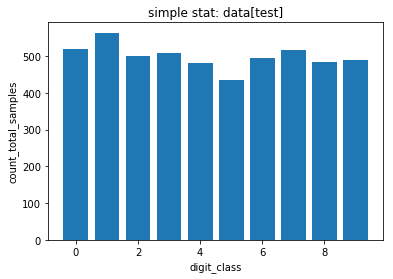

In [10]:
vis_dist_dataloader('test')

## 实验设计

【问题 1】示例：**图像** -> **图像**

【问题 2】目标：**文本** -> **图像**

那是否有什么方式可以把【问题 2】转化为【问题 1】，或者结合【问题 1】的解法？

首先回顾一下【问题 1】的 GAN 的代码过程：

1. 给出来自**原始数据**的真实图片，手动标记全为真（1）；喂给判别器 D，计算误差 1 `error_real`
2. 给出来自**生成器 G**的生成图片，手动标记全为假（0）；喂给判别器 D，计算误差 2 `error_fake`
3. 反向传播「误差 1 + 误差 2」（`error_D = error_real + error_fake`），用来**训练判别器 D**
4. 对生成图片，重新手动标记全为真（1）；喂给判别器 D，计算误差 3 `error_G`
5. 使用误差 3 `error_G` 来**训练生成器 G**

### 方案 1: GAN(11 分类)

这种方案思路是：把原始判断「真/假」的**二分类**问题，转化为判断「真0/真1/…/真9/假图」的**十一分类**问题

那么只要更改标记即可：

+ 对真实图片，标记使用图片对应标签 `label`
+ 对假图，在**训练 D 前**，喂给 D 时仍然标记为 0
+ 对假图，在**训练 G 前**，喂给 D 的标签使用图片对应标签 `label`

### 方案 2: GAN(2 分类) + CNN(10 分类)

这种方案的思路是：在 GAN 的判别器判别假图为真后，将假图输入给另一个预训练 CNN（如 VGG）来判断这个假图的数字，然后在 CNN 固定权重的前提下用 CNN 输出结果反传梯度，以便修正生成器网络 G。

## 实验执行

### 方案 1: GAN(11 分类)

### 方案 2: GAN(2 分类) + CNN(10 分类)